## Introduction
Aspect based sentiment analysis, can be viewed as two separate problems; Mining the appropriate aspects which are being either explicitly or implicitly mentioned within the text, and finding the polarity of sentiment allocated to each aspect found within. Both of these steps pose major difficulties as aspect identification (topic modeling) can be extremely difficult. One of the issues I noticed while performing my aspect mining process was that the labels assigned by the human labeler can be inconsistent and in cases fairly arbitrary. For instance there is a selective amount of ambiguity regarding what an aspect of the review might be e.g. *'I just got an older 866 Mhz system with 512 PC 133 RAM and it also runs fine on that.'* is a sentence from a review on Norton from the given data set - the labeled aspect is memory usage, my first approach at aspect labeling was to use an apriory algorithm approach which got system as the aspect and my second approach a LDA sampling of the data returned run as the aspect. While neither are as exact as the original label it is hard to argue that they aren't also aspects related to the sentiment of the review i.e. system performance and how well the program runs. This is also a product of the labeling criteria the dataset took. In my opinion the aspect labeling could have been stricter regarding the number of categories. An additional layer of difficulty of this problem is that the number of aspects labeled to each sentence can be greater than one. Within my experimentation on this problem I don't focus on this as a major component rather compare the overlap between the given and my generated labels. Experimenting within this project I decided to try both the approach of keeping the aspect identification and the sentiment analysis separate and also having a technique whereby the are joined and sentiment can theoretically be different between aspects occupying the same sentence.

In [4]:
import os
import re

from collections import Counter

from thefuzz import fuzz

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import pandas as pd

import nltk
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import string

import spacy
nlp = spacy.load("en_core_web_sm")

from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

import numpy as np

## Preprocessing Text Data
The First step of the preprocessing of the data is reading all of the files within each of the three review sub categories into a dictionary. Initially I was having encoding issues so I experimented with a number of different options until finding that using the encoding ISO-8859-1 allowed me to import all of the files without issue. The text is then subsiquently stored in a dictionary with the product name mined from the title of the text document.

In [5]:
def read_in(review_folder):
    reviews = {}
    files = os.listdir(f'./Data/{review_folder}')
    for file in files:
        if file == 'readme.txt':
            continue
        with open(f'./Data/{review_folder}/{file}', 'r', encoding="ISO-8859-1") as f:
            text = f.read()
        # removes .txt from end of key
        reviews[file[:-4]] = text
    return reviews

In [6]:
os.listdir('./Data/')

['Customer_review_data', 'Reviews-9-products', 'CustomerReviews-3_domains']

In [7]:
customer_review_data = read_in('Customer_review_data')

In [8]:
customer_review_data.keys()

dict_keys(['Nokia 6610', 'Canon G3', 'Creative Labs Nomad Jukebox Zen Xtra 40GB', 'Nikon coolpix 4300', 'Readme', 'Apex AD2600 Progressive-scan DVD player'])

In [9]:
three_domains = read_in('CustomerReviews-3_domains')

In [10]:
nine_products = read_in('Reviews-9-products')

### Split the Reviews and Currate the Tags
\+ represents a positive, and \- a negative sentiment on that aspect of the entity.
I will remove the neumerical strenght given to the classification as this is very arbitary and will complicate classfication further than what is necessary.
The following tags I have decided to remove from the text due to try and limit the scope of the problem. I achieved this by replacing sub-string elements consisting of these tags with an empty string
- \[u\] : feature not appeared in the sentence.<br>
- \[p\] : feature not appeared in the sentence. Pronoun resolution is needed.<br>
- \[s\] : suggestion or recommendation.<br>
- \[cc\]: comparison with a competing product from a different brand.<br>
- \[cs\]: comparison with a competing product from the same brand.<br>
  
The first review processing function splits the entirity of the reviews is the understanding that each individual review begins with a title tag represented in the text by \[t\], this deliminator of reviews is constant throught the nine_products dataset for all products except the ipod, for which they are conspicuously absent. This is also the case for the products within the domain of customer_review_data and three_domains. I attempted to address the differences in formatting later on in the project but had difficulties relating to the label and feature splitting mid way during processing, I decided that this wasn't worth the hastle and stuck to 8 product categories which seems like more than enough data for the techniques I wanted to evaluate.
for the nine_product reviews database seperate reviews are now contained in a list.


In [11]:
def review_processor(reviews):
    add_tags = ['[u]', '[p]', '[s]', '[cc]', '[cs]']
    for key in reviews.keys():
        prod_reviews = []
        preprocessed_text = reviews[key]
        # I will remove these tags for now as I believe this information is
        # difficult to make useful for my techniques
        for tag in add_tags:
            preprocessed_text = preprocessed_text.replace(tag, '')
        # split the individual reviews by the title tag
        split_texts = preprocessed_text.split('[t]')
        if len(split_texts) == 1: # review not split by a [t]
            reviews[key] = split_texts
        else:
            split_texts = split_texts[1:]
            reviews[key] = split_texts

In [12]:
review_processor(nine_products)

In [15]:
nine_products.keys()

dict_keys(['Nokia 6600', 'Hitachi router', 'ipod', 'Canon PowerShot SD500', 'MicroMP3', 'Linksys Router', 'Diaper Champ', 'Canon S100', 'norton'])

In [16]:
nine_products['Nokia 6600']

["\nphone[+3]##I've had this beauty for nearly 2 months now and I truely love it.\nbattery life[-2]##The only disappointment so far has been battery life.\nbattery life[-2]##Mine generally requires a charege every 48 hours or so and I don't really talk on it that much.\n##Why is this phone so great?\n##Simple.\nphone[+3]##It has it all.\nphone[+3]##This is the first phone I know of that has the large bright screen, infrared, bluetooth, USB connector and a speakerphone.\nphone[+3]##If you are looking for an upgrade, this is definitely the phone for you.\n",
 "\n##I got this with the need for a nokia GSM camera-phone with speakerphone.\nsize[+2]##3660 had similar features, but that is big in size.\n6600[+3]##6600 looks and feels nice.\nbluetooth[+3]##This one is full of features(has bluetooth).\nLCD[+3]camera quality[+3]##Especially the LCD is big and the camera quality is among the very best around.\nPDA[+3]##I have set up it's PDA features with avantgo.com where you can download info f

### Seperating The Data Into Feature and Label categories
It is an industry standard in machine learning to split our data into feature and label data in such a way that we can use the data more effectively i.e. training and testing for a supervied learning algorithm and  evaluate our algorithms perform the tasks more generally.<br>
Here I use regular expressions to split on either '##' or '\n'. Labels denotining the aspect and the sentiment polarity will be conained within of the form '*\<aspect\>\[+/-x\]*' where x is a numerical value categorising the percieved strength of the sentiment. If there is no label for the sentence I substitute in a 'neutral' evaluation to replace it.
I decided to use the map function to apply the function to my container of reviews instead of passing the original container to the function to reduce the complexity of writing. However I think that the required additional reformating requiring unpacking and rezipping the contents harms the legibilility of the code, so don't continue this practice throught the project.

In [17]:
def review_to_labels_features(review):
    labels_sentences = re.split('##|\n', review)[1:-1] # removes empty '' elements from the split
    labels = []
    features = []
    for i in range(len(labels_sentences)-1):
        if i % 2 == 0:
            if labels_sentences[i] == '':
                labels.append('neutral')
            else:
                labels.append(labels_sentences[i])
            features.append(labels_sentences[i+1])
    return labels, features

In [18]:
def reformat_feature_label(reviews):
    labels_features = list(zip(*list(map(review_to_labels_features, reviews))))
    labels, features = labels_features[0], labels_features[1]
    return list(labels), list(features)

In [19]:
pre_nokia_6600_labels, nokia_6600_features = reformat_feature_label(nine_products['Nokia 6600'])

In [208]:
pre_nokia_6600_labels

[['phone[+3]',
  'battery life[-2]',
  'battery life[-2]',
  'neutral',
  'neutral',
  'phone[+3]',
  'phone[+3]',
  'phone[+3]'],
 ['neutral',
  'size[+2]',
  '6600[+3]',
  'bluetooth[+3]',
  'LCD[+3]camera quality[+3]',
  'PDA[+3]',
  's/w[+3]',
  'battery life[+3]'],
 ['neutral',
  'phone[-1]',
  'priced[-2]',
  'phone[+3]',
  'use[+3]',
  'neutral',
  'keypad[+3]',
  'neutral',
  'neutral',
  'keypad[+3]',
  'neutral',
  'neutral',
  'look[+2]',
  'interface[+3]',
  'neutral',
  'MMC card[+3]',
  'neutral',
  'Capacity[+3]',
  'Build[+3]',
  'sturdy[+3]',
  'build[+3]',
  'phone[+3]',
  'phone[+3]',
  'Camera[+3]',
  'bluetooth[+3]',
  'display[+3]',
  'colors[+3]',
  'neutral',
  'upgradibility[+3]',
  'neutral',
  'neutral',
  'log[+3]',
  'handsfree[+3]',
  'neutral',
  'processor[-3]ear volume[-2]',
  'battery life[-2]',
  'Video recording[-2]',
  'upgrade[-1]',
  'neutral',
  'neutral',
  'neutral',
  'phone[+3]',
  'neutral',
  'neutral'],
 ['phone[-3]',
  'neutral',
  'phone

### Additional Formating and Normalisation of The Labels
In this function I split the label into a tuple of the two category types - aspect and sentiment. This is already an addmition that the approach I will use is to try and split the problem into two seperate parts of aspect identication and the subsiquent sentiment analysis. An alternative approach could have been to perform supervised learning on the entire original label keeping aspect+ and aspect- as sperate categories. However I belive this would have issues due to the dilution of the number of examples, so would only be appropiate tactic for extreamly large datasets.<br>
Again, here I use regular expressions to perform additional restructuring and deduce the number of aspect, sentiment pairs based on the length of the string once all non +/- have been removed. I process the labels differently if it is a single aspect and sentiment, or multi class. I replace + and - for pos and neg respectively and for review sentences which don't have a label currently I substitute in ('general', 'neu').


In [22]:
def aspect_sentiment_splitter(labels):
    new_labels = []
    for i in range(len(labels)):
        review_labels = labels[i]
        new_review_labels = []
        for n, label in enumerate(review_labels):
            label = re.sub(r'\[|\d\]', '', label)
            # now we need to split the multi label components into lists - issue some are split by a comma others not
            num_labels = len(re.sub(r'[^+-]+', '', label))
            if num_labels > 1:
                if ',' in label:
                    label = label.split(',')
                else:
                    for n, char in enumerate(label):
                        if (char == '+' or char == '-') and n != len(label) - 2:
                            if len(label[:n]) == 1:
                                continue
                            label = label[:n+1] + ',' + label[n+1:]
                    label = label.split(',')
                    label = [item for item in label if item != '']
            new_review_labels.append(label)
        for i, label in enumerate(new_review_labels):
            if isinstance(label, list):
                label_list = label
                for n, label in enumerate(label_list):
                    if label[-1] == "+":
                        label_list[n] = (label[:-1].lower(), 'pos')
                    elif label[-1] == "-":
                        label_list[n] = (label[:-1].lower(), 'neg')
                    else:
                        label_list[n] = ('general', 'neu')
                new_review_labels[i] = label_list
            else:   
                if label[-1] == "+":
                    new_review_labels[i] = (label[:-1].lower(), 'pos')
                elif label[-1] == "-":
                    new_review_labels[i] = (label[:-1].lower(), 'neg')
                else:
                    new_review_labels[i] = ('general', 'neu')
        new_labels.append(new_review_labels)
    return new_labels                   

In [23]:
nokia_6600_labels = aspect_sentiment_splitter(pre_nokia_6600_labels)

In [24]:
nokia_6600_labels

[[('phone', 'pos'),
  ('battery life', 'neg'),
  ('battery life', 'neg'),
  ('general', 'neu'),
  ('general', 'neu'),
  ('phone', 'pos'),
  ('phone', 'pos'),
  ('phone', 'pos')],
 [('general', 'neu'),
  ('size', 'pos'),
  ('6600', 'pos'),
  ('bluetooth', 'pos'),
  [('lcd', 'pos'), ('camera quality', 'pos')],
  ('pda', 'pos'),
  ('s/w', 'pos'),
  ('battery life', 'pos')],
 [('general', 'neu'),
  ('phone', 'neg'),
  ('priced', 'neg'),
  ('phone', 'pos'),
  ('use', 'pos'),
  ('general', 'neu'),
  ('keypad', 'pos'),
  ('general', 'neu'),
  ('general', 'neu'),
  ('keypad', 'pos'),
  ('general', 'neu'),
  ('general', 'neu'),
  ('look', 'pos'),
  ('interface', 'pos'),
  ('general', 'neu'),
  ('mmc card', 'pos'),
  ('general', 'neu'),
  ('capacity', 'pos'),
  ('build', 'pos'),
  ('sturdy', 'pos'),
  ('build', 'pos'),
  ('phone', 'pos'),
  ('phone', 'pos'),
  ('camera', 'pos'),
  ('bluetooth', 'pos'),
  ('display', 'pos'),
  ('colors', 'pos'),
  ('general', 'neu'),
  ('upgradibility', 'pos'),
 

In [25]:
len(nokia_6600_labels)

49

### Flattening Features and Labels to The Sentence Level
Here I use the following comprehension to return the items from each of the review sublists representing the individual sentences of all reviews. I did this as the data is labelled on a sentence level and future algorithms are easier to apply if the data exists in a more linear structure.

In [26]:
def sentence_level_flattener(two_dim_list):
    one_dim_list = [item for sublist in two_dim_list for item in sublist]
    return one_dim_list

In [27]:
sentence_nokia_6600_labels = sentence_level_flattener(nokia_6600_labels)

In [28]:
sentence_nokia_6600_labels

[('phone', 'pos'),
 ('battery life', 'neg'),
 ('battery life', 'neg'),
 ('general', 'neu'),
 ('general', 'neu'),
 ('phone', 'pos'),
 ('phone', 'pos'),
 ('phone', 'pos'),
 ('general', 'neu'),
 ('size', 'pos'),
 ('6600', 'pos'),
 ('bluetooth', 'pos'),
 [('lcd', 'pos'), ('camera quality', 'pos')],
 ('pda', 'pos'),
 ('s/w', 'pos'),
 ('battery life', 'pos'),
 ('general', 'neu'),
 ('phone', 'neg'),
 ('priced', 'neg'),
 ('phone', 'pos'),
 ('use', 'pos'),
 ('general', 'neu'),
 ('keypad', 'pos'),
 ('general', 'neu'),
 ('general', 'neu'),
 ('keypad', 'pos'),
 ('general', 'neu'),
 ('general', 'neu'),
 ('look', 'pos'),
 ('interface', 'pos'),
 ('general', 'neu'),
 ('mmc card', 'pos'),
 ('general', 'neu'),
 ('capacity', 'pos'),
 ('build', 'pos'),
 ('sturdy', 'pos'),
 ('build', 'pos'),
 ('phone', 'pos'),
 ('phone', 'pos'),
 ('camera', 'pos'),
 ('bluetooth', 'pos'),
 ('display', 'pos'),
 ('colors', 'pos'),
 ('general', 'neu'),
 ('upgradibility', 'pos'),
 ('general', 'neu'),
 ('general', 'neu'),
 ('log

In [30]:
len(sentence_nokia_6600_labels)

554

In [31]:
sentence_nokia_6600_features = sentence_level_flattener(nokia_6600_features)

In [240]:
len(sentence_nokia_6600_features)

554

### Use of Pandas Dataframes
At this point in the project I made the desision to move the data into a dataframe, which would allow for easier manipulation and visualisation ofthe underlying data.

In [32]:
# seperate aspects and sentiments into seperate lists
def aspect_sentiment_seperator(sentence_labels):
    aspects = []
    sentiments = []
    for label in sentence_labels:
        if isinstance(label, list):
            a = []
            s = []
            for l in label:
                a.append(l[0])
                s.append(l[1])
            aspects.append(a)
            sentiments.append(s)
        else:
            aspects.append(label[0])
            sentiments.append(label[1])
    return aspects, sentiments

In [33]:
nokia_sentence_aspects, nokia_sentence_sentiments = aspect_sentiment_seperator(sentence_nokia_6600_labels)

In [34]:
nokia_6600_df = df = pd.DataFrame({
    'Sentences': sentence_nokia_6600_features,
    'Aspects': nokia_sentence_aspects,
    'Sentiments': nokia_sentence_sentiments
})

## Data Exploration
### Evaluating Aspect and Sentiment distribution through expansion of multi label sentences
By using the .explode method on the dataframe I was able to expand multi label review sentences onto multiple rows. This allowed me to investigate the sentiment distribution of the reviews and also the most common labeled Aspects underlying the reviews.

In [241]:
nokia_6600_df_exploded = nokia_6600_df.explode(['Aspects', 'Sentiments']) # this splits multi aspect sentences into seperate rows

In [36]:
nokia_6600_df_exploded.head(20)

,Sentences,Aspects,Sentiments
0,I've had this beauty for nearly 2 months now a...,phone,pos
1,The only disappointment so far has been batter...,battery life,neg
2,Mine generally requires a charege every 48 hou...,battery life,neg
3,Why is this phone so great?,general,neu
4,Simple.,general,neu
5,It has it all.,phone,pos
6,This is the first phone I know of that has the...,phone,pos
7,"If you are looking for an upgrade, this is def...",phone,pos
8,I got this with the need for a nokia GSM camer...,general,neu
9,"3660 had similar features, but that is big in ...",size,pos


In [37]:
nokia_6600_df_exploded.loc[12]

,Sentences,Aspects,Sentiments
12,Especially the LCD is big and the camera quali...,lcd,pos
12,Especially the LCD is big and the camera quali...,camera quality,pos


In [38]:
nokia_6600_df_exploded['Sentiments'].value_counts() # vast majority of sentiments is positive

Sentiments
pos    310
neu    191
neg    152
Name: count, dtype: int64

### Sentiment distribution
Sentiment distribution is skewed heavily in the direction of positive sentiment with neutral sentiment representing approximately 2/3rds of aspects and negative, 1/2th of aspects. For supervised learning approaches this information is important to know as it allows you to know the baseline performance your model should beat. Howeverthis information is not representative of the sentiment distribution per review. Where the majority fall under neutral sentiment.

<Axes: title={'center': 'Sentiment Distribution for Nokia 6600 With Relation to Aspects'}, xlabel='Sentiments'>

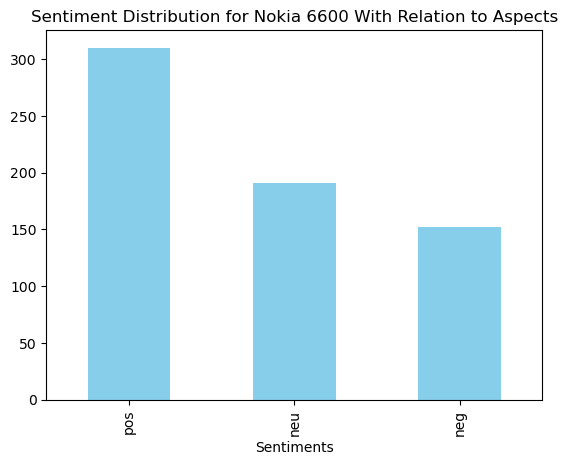

In [249]:
sentiment_counts = nokia_6600_df_exploded['Sentiments'].value_counts()
sentiment_counts.plot(kind='bar', color='skyblue', title='Sentiment Distribution for Nokia 6600 with Relation to Aspects')

In [245]:
sentiment_counts = nokia_6600_df['Sentiments'].value_counts()

<Axes: title={'center': 'Sentiment Distribution for Nokia 6600 with Relation to Reviews'}, xlabel='Sentiments'>

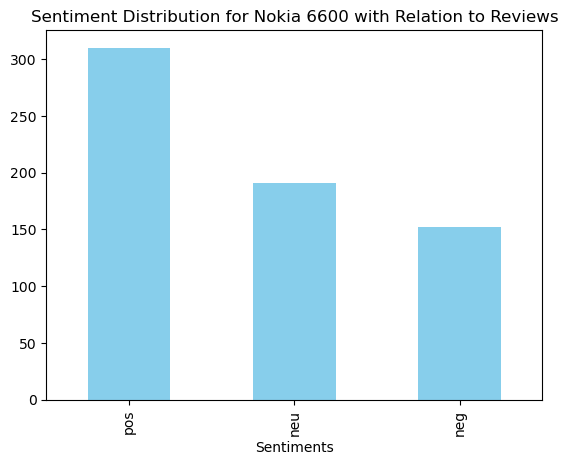

In [250]:
sentiment_counts.plot(kind='bar', color='skyblue', title='Sentiment Distribution for Nokia 6600 with Relation to Reviews')

In [40]:
nokia_6600_df_exploded['Aspects'].value_counts()
    


Aspects
general           191
phone              66
bluetooth          24
camera             16
6600               15
                 ... 
fonts               1
number buttons      1
useable             1
lag                 1
card                1
Name: count, Length: 166, dtype: int64

## Examination of Aspects and use of Fuzzy comparison for dimentionality reduction
While examining the aspect label data I noticed that many 
In total there are 166 unique aspects some of these are plurals, extentions of the same aspect we can use fuzzy comparison technique to group these aspects to the same group
example of each of these e.g.
- ringtones vs. ringtone
- battery vs. battery life

Benefits of using fuzzy comparison instead of stemming or lemmatization for dimentionality reduction here are that we catch aspect names whic have been miss spelt or every comprise of two words.<br>
This fuzzy comparison algorithm uses Levenshtein distance (edit distance) (seatgeek/thefuzz: Fuzzy String Matching in Python, n.d.) which computes a cost based on the number of single character changes required to turn one string into the other. Meaning the number of the algorithm has to change a letter increases the cost by 1. A ratio of similarity can then be computed by calculating the cost normalised reletive to the lengths of the strings involved. Fuzzy comparison was used by Hu and Lui for dimentionality reduction during frequent features generation and opinion word extraction stage of their paper 'Mining Opinion Features in Customer Reviews' (2004).

<Axes: title={'center': 'Top 50 Nokia 6600 labled aspects'}, ylabel='Aspects'>

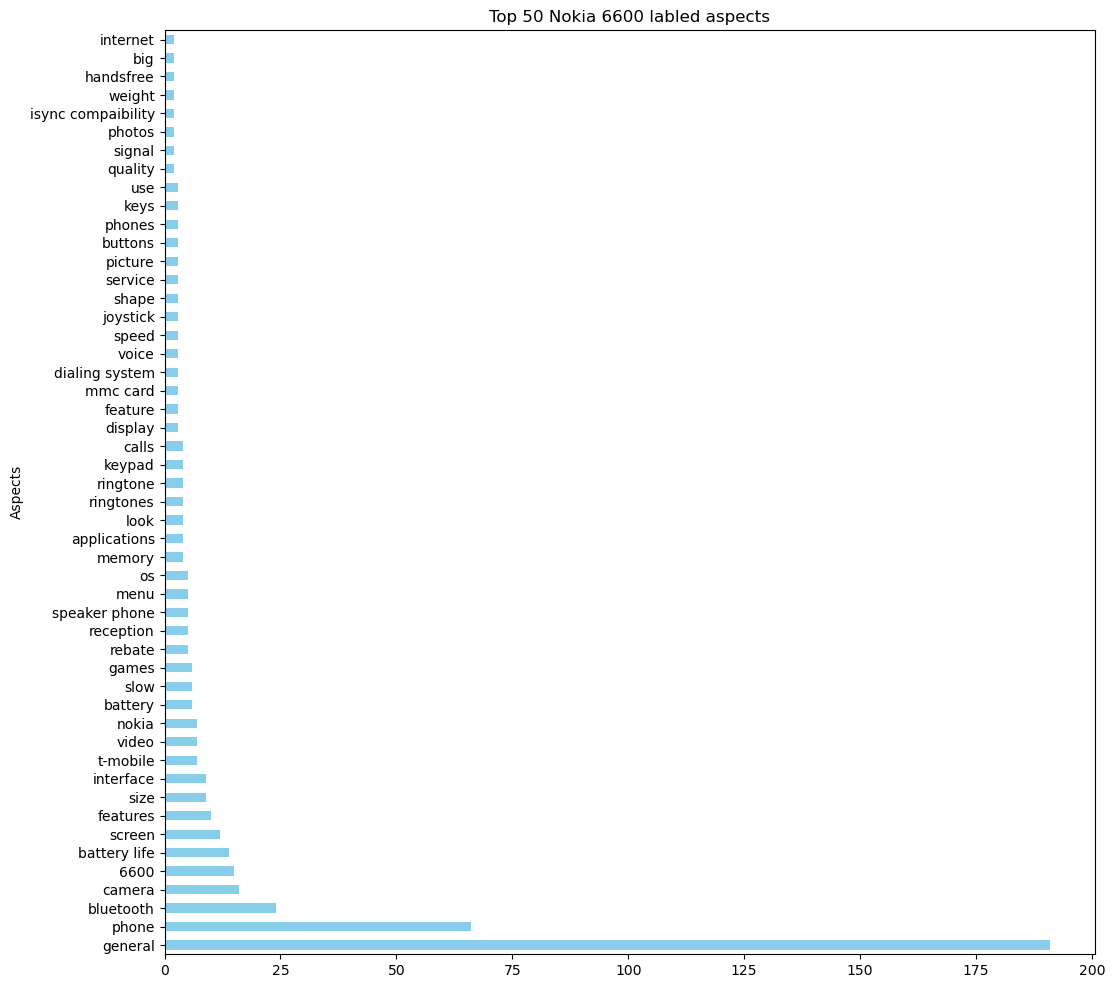

In [41]:
top_50 = nokia_6600_df_exploded['Aspects'].value_counts()[:50] # top 50 aspects 
top_50.plot(kind='barh', color='skyblue', figsize=(12, 12), title='Top 50 Nokia 6600 labled aspects')

In [251]:
def fuzzy_aspect_homogenizer(unique_aspects, aspect_counts):
    '''
    Description:
    Takes in the aspects labels and measures similarity between them
    using a fuzzy similarity algorithm from thefuzz library
    Input:
    unique_aspects - container type of unique aspects
    aspect_counts - Series of counts of the occurances of aspect labels
    Output:
    Dictionary of mappings to change to the more abreviated aspect category e.i. 'phones':'phone'
    '''
    homogenize_map = {}
    for aspect1 in unique_aspects:
        for aspect2 in reversed(unique_aspects):
            if fuzz.ratio(aspect1, aspect2) > 73 and aspect1 != aspect2:
                # to avoid issues with miss spelling favour the characterisation with the highest count
                if (aspect2, aspect1) not in homogenize_map.keys() and aspect_counts[aspect1] <= aspect_counts[aspect2]:
                    if aspect_counts[aspect1] == aspect_counts[aspect2] and len(aspect2) > len(aspect1):
                        # given same occurance go with more concise
                        homogenize_map[aspect2] = aspect1
                    else:
                        homogenize_map[aspect1] = aspect2
    
                    
    return homogenize_map

In [252]:
fuzzy_map = fuzzy_aspect_homogenizer(list(nokia_6600_df_exploded['Aspects'].unique()), nokia_6600_df_exploded['Aspects'].value_counts())
print(fuzzy_map)

{'priced': 'price', 'colors': 'color', 'ear volume': 'volume', 'video recording': 'video recorder', 'ring tone': 'ringtones', 'game': 'games', 'large': 'lag', 'ringtones': 'ringtone', 'feature': 'features', 'phones': 'phone', 'pictures': 'picture', 'ringers': 'ringtones', 'user-interfaces': 'interface', 'sony ericsson t610': 'sonyericsson', ' battery life': 'battery life', 'screens': 'screen', 'menus': 'menu', 'isync': 'sync', 'battery': 'battery life', 'video recorders': 'video recording', 'voice recorders': 'video recorders', 'key': 'keys', 'kays': 'keys', 'rebates': 'rebate', ' speaker phone': 'speaker phone', 'joy stick': 'joystick', 'memory card': 'mmc card', 'application': 'applications', 'n6600': '6600', 'mmc memory': 'memory'}


In [44]:
nokia_6600_df_exploded['Aspects'] = nokia_6600_df_exploded['Aspects'].replace(fuzzy_map)

In [45]:
nokia_6600_df_exploded['Aspects'].value_counts() 

Aspects
general           191
phone              69
bluetooth          24
battery life       21
6600               17
                 ... 
fonts               1
number buttons      1
useable             1
downloads           1
card                1
Name: count, Length: 139, dtype: int64

### Fuzzy matching results
Through this I was able to reduce the count of the number of aspects down from 166 to 139, which equates to a **13.2% decrease**. This isn't a major dimentionality decrease but since the overall size of the data is quite small. For training a supervised model this reduction of noise in the labels could have a major effect on the overall performance of the algorithm, techniques such as these are very commonly applied to multi-label classification problems (Siblini, Kuntz and Meyer, 2021).

<Axes: title={'center': 'Top 50 Nokia 6600 Labled Aspects, Reduced Using Fuzz'}, ylabel='Aspects'>

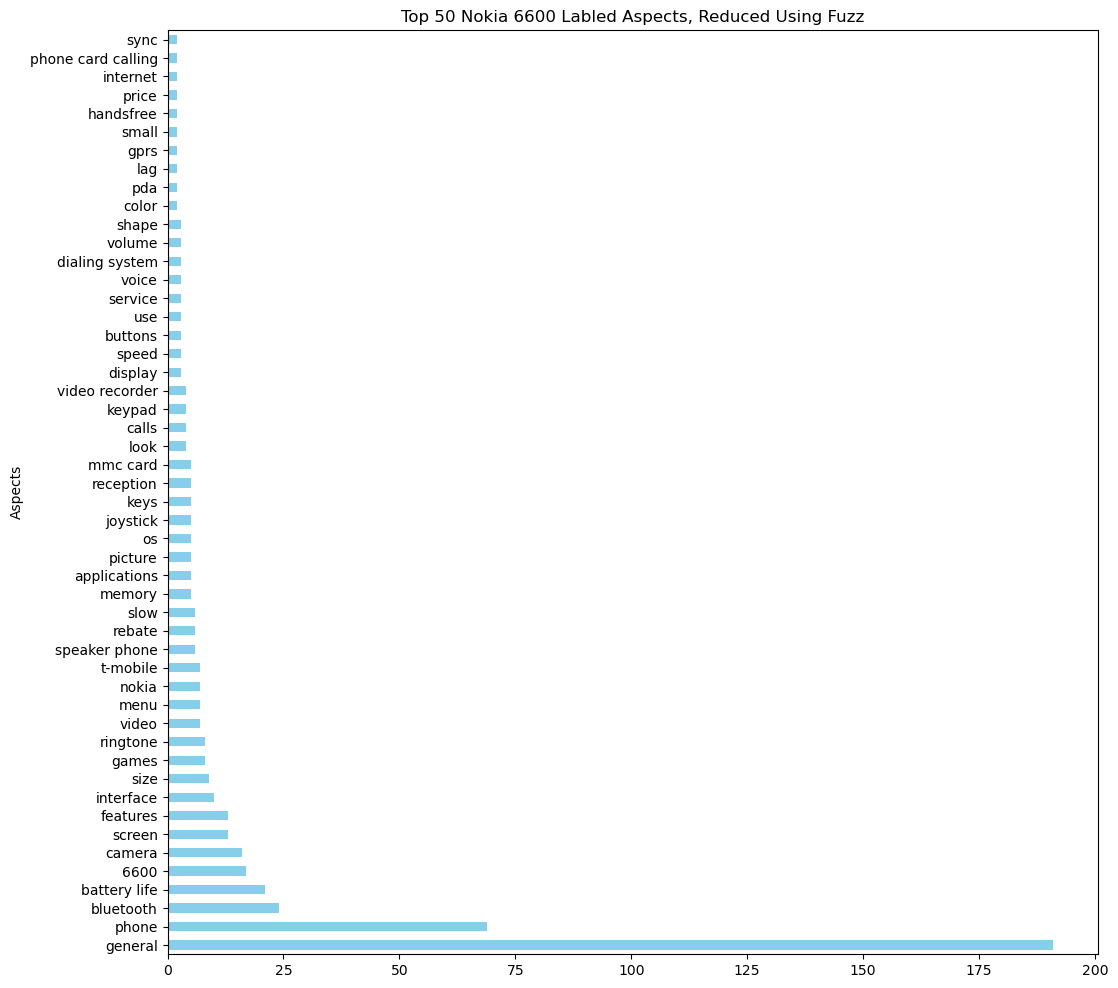

In [46]:
top_50 = nokia_6600_df_exploded['Aspects'].value_counts()[:50] # top 50 aspects 
top_50.plot(kind='barh', color='skyblue', figsize=(12, 12),
            title='Top 50 Nokia 6600 Labled Aspects, Reduced Using Fuzz')

In [47]:
## turn this into a mapping dictionary to modify the elements with

In [48]:
nokia_6600_df_exploded['Aspects'].unique()

array(['phone', 'battery life', 'general', 'size', '6600', 'bluetooth',
       'lcd', 'camera quality', 'pda', 's/w', 'price', 'use', 'keypad',
       'look', 'interface', 'mmc card', 'capacity', 'build', 'sturdy',
       'camera', 'display', 'color', 'upgradibility', 'log', 'handsfree',
       'processor', 'volume', 'video recorder', 'upgrade', 'screen',
       'dial', 'keys', 'feels', 'bulky', 'features', 'transfer', 'slow',
       'looking', 'shape', 'joystick', 'small', 'nokia', 'versatility',
       'audio quality', 'ringtones', 'games', 'wide', 'construction',
       'operation', 'instruction booklet', 'applications',
       'dependability', 'stylized', 'big', 'memory', 'transmission',
       'mhz', 'coverage', 'service', 'operating system', 'video',
       'downloads', 'photos', 'lag', 'useable', 'number buttons', 'fonts',
       'ringtone', 'time', 'modem', 'carrier', 'phone card calling',
       'hear', 'buttons', 'menu', 'picture', 'band', 'color tft display',
       'multime

In [49]:
nokia_6600_df_exploded[nokia_6600_df_exploded['Aspects'] == 't-mobile'][['Sentences', 'Sentiments']]

,Sentences,Sentiments
352,"I really regret signing up with T-Mobile, but ...",neg
456,I also am loving T-Mobile (100 times better th...,pos
457,you actually can talk to a real person for sup...,pos
458,Have had the Nokia 6600 for a year now and am ...,pos
471,I've had nothing but good luck with T-Mobile.,pos
474,It seems to be a much more user friendly compa...,pos
475,I recommend T-Mobile and the Nokia 6600 withou...,pos


## Systems level algorithm Stratergy Aspect Based Sentiment Analysis
For my initial stratergy I chose to take a similar approach to the following figure:
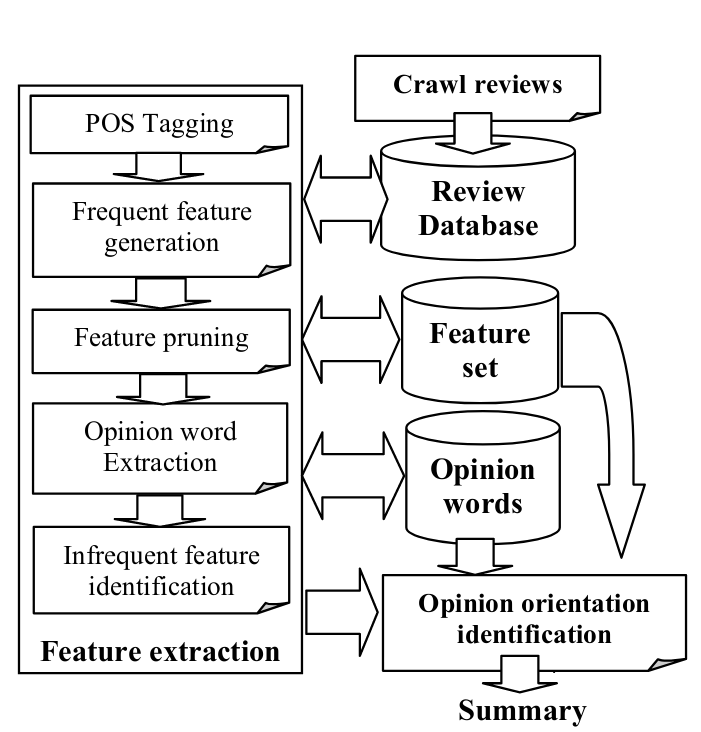
<p style="text-align: center;"> Figure 1: Hu and Li's summerization of Aspect based opinion mining techniques (2004)</p>

#### Modified Approach
- Step 1. Cleaning the sentence data for feature extraction, removal of punctuation, stop word and other information which make the sentences harder to parse. Including this as a column of my dataframe called Filtered Sentences <br>
- Step 2. Performing POS tagging on these Filtered Sentences - new column 'Tagged Sentences' <br>
- Step 3. Perform Noun chunking on sentences using spacy<br>
- Step 4. Get all linear (word by word) 3 word sub strings from these chunks append to a list of transactions for each sentence<br>
- Step 5. Pass transactions to TransactionEncoder() forms using  one-hot encoding a boolean matrix on whether or not a transaction occurs in that sentence.<br>
- Step 6. Pass this one-hot transaction occurance matrix to the apriori algorithm, which returns all transactions which meet the given support threshhold in our case 0.01.<br>
- Step 7. Remove cooccuring transactions e.i. only return transactions with list length 1<br>
- Step 8. Remove nonsense results all non Noun types and with lenth less than than 3. Keep only string noun phrases as extracted feautres<br>
- Step 9. Parse monogram, bigram, and trigram versions of the filtered sentences if noun phrase matches one of the extracted features append to list of mined aspects for that review<br>
- Step 10. Opinion word extraction find the neighboring adjectives within tagged sentences capture the name and index as well as the index of the mined aspects
- Step 11. Use a VADER sentiment analysis tool from the nltk library to find the compound polarity of the adjective, multiply this by $\frac{1}{x}$ were x is the distance between the mined aspect and the adjective i.e. the absolute difference in index. This is summed for all neighboring adjectives
- Step 12. sentiment is then classified - positive > 0, neutral = 0, negative < 0.

### Reasoning and Explaination
##### Spacy
Spacy provides a convinient, yet relitively commpute intensive method to perform PoS and Noun chunking. It does so using increasingly large CNNs which are pre-trained on a large variety of labbled data. <br>
Using this method I only capture words which my tagger thinks could be nouns.
##### Only Explict Aspects
A weakness of this approach is I only get aspect which are explicitly mentioned within my review sentence. and never aspects which appear
implicitly i.e. 'it doesn't get loud' would be an implicity judgement on the speakers for this product. <br>
##### Use of N-Grams
I use \[1-3\]-grams due 3 being the maximum length of my aspect. In order to reduce extra aspects, I determine which smaller mined aspects are sub words of the longer ones e.i. remove 'phone' if 'cell phone' is already a mined aspect.
##### Heuristic Distance From Adjective
For all adjectives in the sentence there effect on the overall sentiment of the mined aspect is a function of its distance away. In this way it is possible to get different polarity scores for multiple mined aspects. One issue is that this is only a simple heuristic therefore isn't capturing the underlying sense of the words. An example where this would perform poorly is 'The phone is really terrible, battery life is however really amazing'. The battery life aspect is more effected by the terrible adjective than the amazing adjective based on distance. Additional issues stem from lack of negation checking for adjectives.
##### VADER
The VADER object I use is NLTK's implementation is a computational sentiment analysis engine, created from a gold standard human-curated sentiment lexicon. One benefit of using a lexicon such as this is that it doens't require training (Hutto and Gilbert, 2014). A weakness of this is that it is overly generalised and therefore doesn't evaluate the sentiment polarity of adjectives relating directly to you topic, i.e. it doesn't think that 'slow' is a negative description, when the aspect is a computer or phone this is obviously negative. 

In [50]:
punctuation = string.punctuation



def punc_remover(sentences):
    replacement_sentences = []
    for sentence in sentences:
        replacement = ''
        for char in sentence:
            if char not in punctuation:
                replacement = replacement + char
        replacement_sentences.append(replacement)
    return replacement_sentences

def stop_remover(sentences):
    replacement_sentences = []
    stop_words = set(stopwords.words('english'))
    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
        replacement_sentence = ' '.join(filtered_words)
        replacement_sentences.append(replacement_sentence)
    return replacement_sentences

In [51]:
no_stop_sentences = stop_remover(nokia_6600_df['Sentences'])

In [52]:
filtered_sentences = punc_remover(no_stop_sentences)

In [53]:
nokia_6600_df['Filtered Sentences'] = [sentence.lower() for sentence in filtered_sentences]

In [54]:
def sentence_tagger(filtered_sentence):
    spacy_sentence = nlp(filtered_sentence)
    word_tags = []
    for token in spacy_sentence:
        word_tags.append((token.text, token.tag_))
    return word_tags

In [55]:
nokia_6600_df['Tagged Sentences']=nokia_6600_df['Filtered Sentences'].apply(sentence_tagger) 

In [56]:
nokia_6600_df

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD..."
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN..."
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)..."
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]"
4,Simple.,general,neu,simple,"[(simple, JJ)]"
...,...,...,...,...,...
549,"Many of these programs are shareware, some can...",programs,pos,many programs shareware purchased paying littl...,"[(many, JJ), (programs, NNS), (shareware, VBP)..."
550,"It uses the extendable MMC memory, it is perfe...",mmc memory,pos,uses extendable mmc memory perfect storing vid...,"[(uses, VBZ), (extendable, JJ), (mmc, NNP), (m..."
551,Its nice look is also a plus.,look,pos,nice look also plus,"[(nice, JJ), (look, NN), (also, RB), (plus, CC)]"
552,"And also, since it is tri band and since it us...","[sim, card]","[neg, pos]",also since tri band since uses simcard use eur...,"[(also, RB), (since, IN), (tri, JJ), (band, NN..."


In [57]:
spacy.explain('JJS')

'adjective, superlative'

In [58]:
nokia_6600_df['Noun Chunks']=[list(nlp(sentence.lower()).noun_chunks) for sentence in filtered_sentences]

In [59]:
nokia_6600_df['Noun Chunks'][:100]

0                              [(ve, beauty)]
1      [(disappointment, far, battery, life)]
2     [(mine), (charege), (every, 48, hours)]
3                                          []
4                                          []
                       ...                   
95    [(quite, big, handphone, 65000, color)]
96                                 [(camera)]
97    [(one, quite, slow, open, application)]
98             [(minutes, open, application)]
99                                         []
Name: Noun Chunks, Length: 100, dtype: object

In [60]:
def get_linear_combinations(lst, lengths):
    lst = [str(element) for element in lst]
    results = []
    for length in lengths:
        for i in range(len(lst)-length+1):
            combo = lst[i:i+length]
            if len(combo) == length:
                noun_phrase = ' '.join(combo)
                results.append(noun_phrase)
    return results

In [61]:
def frequent_features_generation(all_noun_chunks):
    transactions = []
    for sentence_chunks in all_noun_chunks:
        transaction = []
        for sentence_chunk in sentence_chunks:
            transaction += get_linear_combinations(sentence_chunk, (3,2,1))
        transactions.append(transaction)
    return transactions
        


In [62]:
nokia_6600_transactions = frequent_features_generation(nokia_6600_df['Noun Chunks'])

In [64]:
nokia_6600_transactions[1]

['disappointment far battery',
 'far battery life',
 'disappointment far',
 'far battery',
 'battery life',
 'disappointment',
 'far',
 'battery',
 'life']

Use an apriori algorithm to detetermine which of the elements transactions are frequent features

In [65]:
te = TransactionEncoder()
te_ary = te.fit(nokia_6600_transactions).transform(nokia_6600_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,,amazon,bar,bar soap,bluejacking,bluejacking,case,cell,cell phone,contact,...,year generally happy,yes,yes bit,zealand,zealand australia,zerostar,zerostar rating,zoom,zoom speaker,zoom speaker good
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
550,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
551,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
552,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
itemsets = apriori(df, min_support=0.01, use_colnames=True,)
single_itemsets = itemsets[itemsets['itemsets'].apply(lambda x: len(x) == 1)]
cleaned_items = np.array([list(fs)[0] for fs in single_itemsets['itemsets']])

In [67]:
len(cleaned_items)

79

In [68]:
single_itemsets.loc[:, 'itemsets'] = cleaned_items

In [69]:
single_itemsets

,support,itemsets
0,0.030686,
1,0.012635,1
2,0.018051,2
3,0.018051,3
4,0.028881,6600
...,...,...
74,0.018051,two
75,0.028881,use
76,0.023466,video
77,0.010830,w


In [70]:
# remove meaningless items ei those with length less than 2
meaningful_itemsets = single_itemsets[single_itemsets['itemsets'].apply(lambda x: len(x) > 2)]

In [71]:
meaningful_itemsets

,support,itemsets
4,0.028881,6600
5,0.012635,applications
6,0.034296,battery
7,0.021661,battery life
8,0.016245,best
...,...,...
73,0.012635,transfer
74,0.018051,two
75,0.028881,use
76,0.023466,video


In [72]:
# remove items from extracted noun phrases which are adjectives rather than nouns
meaningful_itemsets = meaningful_itemsets[meaningful_itemsets['itemsets'].apply(lambda x: nltk.pos_tag([x])[0][1] != 'JJ')]

In [73]:
noun_itemsets = meaningful_itemsets[meaningful_itemsets['itemsets'].apply(lambda x: nltk.pos_tag([x])[0][1] == 'NN')]

In [74]:
meaningful_itemsets

,support,itemsets
4,0.028881,6600
5,0.012635,applications
6,0.034296,battery
7,0.021661,battery life
8,0.016245,best
...,...,...
73,0.012635,transfer
74,0.018051,two
75,0.028881,use
76,0.023466,video


In [75]:
top_meaningful_itemsets = meaningful_itemsets.sort_values(by='support', ascending=False)
top_meaningful_itemsets = top_meaningful_itemsets.reset_index(drop=True)


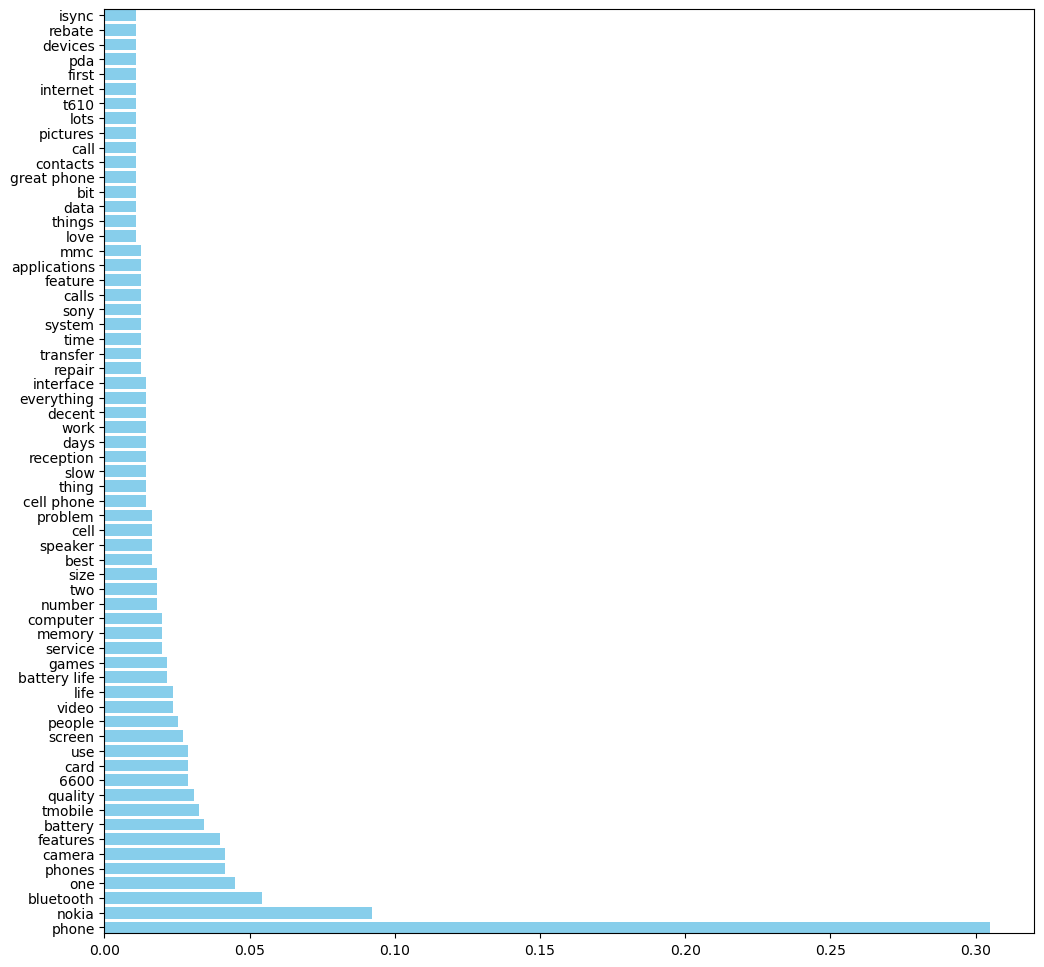

In [76]:
plt.figure(figsize=(12, 12))
plt.barh(top_meaningful_itemsets['itemsets'], top_meaningful_itemsets['support'], color='skyblue')
plt.margins(y=0)

In [77]:
top_meaningful_itemsets

,support,itemsets
0,0.305054,phone
1,0.092058,nokia
2,0.054152,bluetooth
3,0.045126,one
4,0.041516,phones
...,...,...
58,0.010830,first
59,0.010830,pda
60,0.010830,devices
61,0.010830,rebate


## Find meaningful items within sentences

In [78]:
extracted_features = top_meaningful_itemsets['itemsets'].values

In [79]:
extracted_features

array(['phone', 'nokia', 'bluetooth', 'one', 'phones', 'camera',
       'features', 'battery', 'tmobile', 'quality', '6600', 'card', 'use',
       'screen', 'people', 'video', 'life', 'battery life', 'games',
       'service', 'memory', 'computer', 'number', 'two', 'size', 'best',
       'speaker', 'cell', 'problem', 'cell phone', 'thing', 'slow',
       'reception', 'days', 'work', 'decent', 'everything', 'interface',
       'repair', 'transfer', 'time', 'system', 'sony', 'calls', 'feature',
       'applications', 'mmc', 'love', 'things', 'data', 'bit',
       'great phone', 'contacts', 'call', 'pictures', 'lots', 't610',
       'internet', 'first', 'pda', 'devices', 'rebate', 'isync'],
      dtype=object)

In [80]:
nokia_6600_df

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]"
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]"
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]"
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[]
4,Simple.,general,neu,simple,"[(simple, JJ)]",[]
...,...,...,...,...,...,...
549,"Many of these programs are shareware, some can...",programs,pos,many programs shareware purchased paying littl...,"[(many, JJ), (programs, NNS), (shareware, VBP)...","[(many, programs), (little, bit, bucks)]"
550,"It uses the extendable MMC memory, it is perfe...",mmc memory,pos,uses extendable mmc memory perfect storing vid...,"[(uses, VBZ), (extendable, JJ), (mmc, NNP), (m...","[(extendable, mmc, memory, perfect, storing, v..."
551,Its nice look is also a plus.,look,pos,nice look also plus,"[(nice, JJ), (look, NN), (also, RB), (plus, CC)]","[(nice, look)]"
552,"And also, since it is tri band and since it us...","[sim, card]","[neg, pos]",also since tri band since uses simcard use eur...,"[(also, RB), (since, IN), (tri, JJ), (band, NN...","[(tri, band), (europe), (many, parts, world)]"


In [81]:
# tokenize the sentences
nokia_6600_df['Monograms']=nokia_6600_df['Filtered Sentences'].apply(lambda x: word_tokenize(x))

In [82]:
nokia_6600_df.head()

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]"
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]"
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48..."
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]"
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple]


In [83]:
nokia_6600_df['Bigrams'] = nokia_6600_df['Monograms'].apply(lambda x:list(bigrams(x)))

In [84]:
nokia_6600_df['Trigrams'] = nokia_6600_df['Monograms'].apply(lambda x: list(trigrams(x)))

In [85]:
nokia_6600_df

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms,Bigrams,Trigrams
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]","[(ve, beauty), (beauty, nearly), (nearly, 2), ...","[(ve, beauty, nearly), (beauty, nearly, 2), (n..."
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]","[(disappointment, far), (far, battery), (batte...","[(disappointment, far, battery), (far, battery..."
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48...","[(mine, generally), (generally, requires), (re...","[(mine, generally, requires), (generally, requ..."
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]","[(phone, great)]",[]
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple],[],[]
...,...,...,...,...,...,...,...,...,...
549,"Many of these programs are shareware, some can...",programs,pos,many programs shareware purchased paying littl...,"[(many, JJ), (programs, NNS), (shareware, VBP)...","[(many, programs), (little, bit, bucks)]","[many, programs, shareware, purchased, paying,...","[(many, programs), (programs, shareware), (sha...","[(many, programs, shareware), (programs, share..."
550,"It uses the extendable MMC memory, it is perfe...",mmc memory,pos,uses extendable mmc memory perfect storing vid...,"[(uses, VBZ), (extendable, JJ), (mmc, NNP), (m...","[(extendable, mmc, memory, perfect, storing, v...","[uses, extendable, mmc, memory, perfect, stori...","[(uses, extendable), (extendable, mmc), (mmc, ...","[(uses, extendable, mmc), (extendable, mmc, me..."
551,Its nice look is also a plus.,look,pos,nice look also plus,"[(nice, JJ), (look, NN), (also, RB), (plus, CC)]","[(nice, look)]","[nice, look, also, plus]","[(nice, look), (look, also), (also, plus)]","[(nice, look, also), (look, also, plus)]"
552,"And also, since it is tri band and since it us...","[sim, card]","[neg, pos]",also since tri band since uses simcard use eur...,"[(also, RB), (since, IN), (tri, JJ), (band, NN...","[(tri, band), (europe), (many, parts, world)]","[also, since, tri, band, since, uses, simcard,...","[(also, since), (since, tri), (tri, band), (ba...","[(also, since, tri), (since, tri, band), (tri,..."


In [86]:
def stringify_ngrams(list_of_ngrams):
    string_ngrams = []
    for ngram in list_of_ngrams:
        string_ngram = ' '.join(ngram)
        string_ngrams.append(string_ngram)
    return string_ngrams
        

In [87]:
nokia_6600_df['Bigrams'] = nokia_6600_df['Bigrams'].apply(stringify_ngrams)

In [88]:
nokia_6600_df['Trigrams'] = nokia_6600_df['Trigrams'].apply(stringify_ngrams)

In [89]:
def extracted_feature_allocation(extracted_features, trigrams, bigrams, monograms):
    tris = [feature for feature in extracted_features if len(feature.split(' ')) == 3]
    bis = [feature for feature in extracted_features if len(feature.split(' ')) == 2]
    monos = [feature for feature in extracted_features if len(feature.split(' ')) == 1]
    
    found_tri_features = []
    for sentence_trigrams in trigrams:
        tri_sentence_features = []
        for trigrams in sentence_trigrams:
            for tri in tris:
                if tri == trigrams:
                    tri_sentence_features.append(tri)
        found_tri_features.append(tri_sentence_features)
    
    found_bi_features = []
    for sentence_bigrams in bigrams:
        bi_sentence_features = []
        for bigrams in sentence_bigrams:
            #print(bigrams)
            for bi in bis:
                if bi == bigrams:
                    bi_sentence_features.append(bi)
        found_bi_features.append(bi_sentence_features)
    
    found_mono_features = []
    for sentence_monograms in monograms:
        mono_sentence_features = []
        for monograms in sentence_monograms:
            for mono in monos:
                if mono == monograms:
                    mono_sentence_features.append(mono)
        found_mono_features.append(mono_sentence_features) 
          
    collected_aspects_column = []
    for i in range(len(found_tri_features)):
        all_aspects = []
        tri_aspects = set(found_tri_features[i])
        
        bi_aspects = set(found_bi_features[i])
        mono_aspects = set(found_mono_features[i])
        collected_aspects_column.append(tri_aspects | bi_aspects | mono_aspects)
    return collected_aspects_column

In [90]:
collected_aspects_column = extracted_feature_allocation(extracted_features, nokia_6600_df['Trigrams'], nokia_6600_df['Bigrams'], nokia_6600_df['Monograms'])

In [91]:
nokia_6600_df['Mined Aspects'] = collected_aspects_column

In [92]:
nokia_6600_df.head()

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms,Bigrams,Trigrams,Mined Aspects
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]","[ve beauty, beauty nearly, nearly 2, 2 months,...","[ve beauty nearly, beauty nearly 2, nearly 2 m...",{love}
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]","[disappointment far, far battery, battery life]","[disappointment far battery, far battery life]","{battery life, battery, life}"
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48...","[mine generally, generally requires, requires ...","[mine generally requires, generally requires c...",{}
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]",[phone great],[],{phone}
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple],[],[],{}


In [93]:
def is_word_in_string(word, text):
    pattern = r'\b' + re.escape(word) + r'\b'
    match = re.search(pattern, text)
    return bool(match)

In [94]:
def mined_aspect_reduction(mined_aspects):
    extra_aspects = set()
    for aspect_1 in mined_aspects:
         for aspect_2 in mined_aspects:
                if aspect_1 != aspect_2 and is_word_in_string(aspect_1, aspect_2):
                    extra_aspects.add(aspect_1)
    reduced_aspects = mined_aspects - extra_aspects
    return reduced_aspects

In [95]:
nokia_6600_df['Mined Aspects'] = nokia_6600_df['Mined Aspects'].apply(mined_aspect_reduction)

In [96]:
nokia_6600_df

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms,Bigrams,Trigrams,Mined Aspects
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]","[ve beauty, beauty nearly, nearly 2, 2 months,...","[ve beauty nearly, beauty nearly 2, nearly 2 m...",{love}
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]","[disappointment far, far battery, battery life]","[disappointment far battery, far battery life]",{battery life}
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48...","[mine generally, generally requires, requires ...","[mine generally requires, generally requires c...",{}
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]",[phone great],[],{phone}
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple],[],[],{}
...,...,...,...,...,...,...,...,...,...,...
549,"Many of these programs are shareware, some can...",programs,pos,many programs shareware purchased paying littl...,"[(many, JJ), (programs, NNS), (shareware, VBP)...","[(many, programs), (little, bit, bucks)]","[many, programs, shareware, purchased, paying,...","[many programs, programs shareware, shareware ...","[many programs shareware, programs shareware p...",{bit}
550,"It uses the extendable MMC memory, it is perfe...",mmc memory,pos,uses extendable mmc memory perfect storing vid...,"[(uses, VBZ), (extendable, JJ), (mmc, NNP), (m...","[(extendable, mmc, memory, perfect, storing, v...","[uses, extendable, mmc, memory, perfect, stori...","[uses extendable, extendable mmc, mmc memory, ...","[uses extendable mmc, extendable mmc memory, m...","{mmc, pictures, memory}"
551,Its nice look is also a plus.,look,pos,nice look also plus,"[(nice, JJ), (look, NN), (also, RB), (plus, CC)]","[(nice, look)]","[nice, look, also, plus]","[nice look, look also, also plus]","[nice look also, look also plus]",{}
552,"And also, since it is tri band and since it us...","[sim, card]","[neg, pos]",also since tri band since uses simcard use eur...,"[(also, RB), (since, IN), (tri, JJ), (band, NN...","[(tri, band), (europe), (many, parts, world)]","[also, since, tri, band, since, uses, simcard,...","[also since, since tri, tri band, band since, ...","[also since tri, since tri band, tri band sinc...",{use}


In [97]:
def opinion_word_finder(mined_aspects, tagged_sentence):
    adjective_indexes = []
    aspect_indexes = []
    for aspect in mined_aspects:  
        for n, word_tag in enumerate(tagged_sentence):
            if (word_tag[1] == 'JJ' or word_tag[1] == 'JJS') and len(adjective_indexes) == 0:  
                adjective_indexes.append((word_tag[0], n)) 
            if word_tag[0] == aspect.split()[0]:
                aspect_indexes.append((aspect, n)) 
    return adjective_indexes, aspect_indexes

In [98]:
nokia_6600_df['Indicies'] = nokia_6600_df.apply(lambda row: opinion_word_finder(row['Mined Aspects'], row['Tagged Sentences']), axis=1)


In [99]:
nokia_6600_df.head(-10)

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms,Bigrams,Trigrams,Mined Aspects,Indicies
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]","[ve beauty, beauty nearly, nearly 2, 2 months,...","[ve beauty nearly, beauty nearly 2, nearly 2 m...",{love},"([], [(love, 6)])"
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]","[disappointment far, far battery, battery life]","[disappointment far battery, far battery life]",{battery life},"([(disappointment, 0)], [(battery life, 2)])"
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48...","[mine generally, generally requires, requires ...","[mine generally requires, generally requires c...",{},"([], [])"
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]",[phone great],[],{phone},"([(great, 1)], [(phone, 0)])"
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple],[],[],{},"([], [])"
...,...,...,...,...,...,...,...,...,...,...,...
539,you can't do that with a Sony T610 (which i tr...,sony t610,neg,ca nt sony t610 traded 6600,"[(ca, MD), (nt, RB), (sony, VB), (t610, NNP), ...",[(t610)],"[ca, nt, sony, t610, traded, 6600]","[ca nt, nt sony, sony t610, t610 traded, trade...","[ca nt sony, nt sony t610, sony t610 traded, t...","{6600, t610, sony}","([], [(6600, 5), (t610, 3), (sony, 2)])"
540,T610 supports only midi files.,t610,neg,t610 supports midi files,"[(t610, NNP), (supports, VBZ), (midi, NN), (fi...","[(t610), (midi, files)]","[t610, supports, midi, files]","[t610 supports, supports midi, midi files]","[t610 supports midi, supports midi files]",{t610},"([], [(t610, 0)])"
541,"N6600 supports midi, wav, amr, mp3 etc.",n6600,pos,n6600 supports midi wav amr mp3 etc,"[(n6600, NNPS), (supports, VBZ), (midi, NNP), ...","[(n6600), (midi, wav, amr, mp3)]","[n6600, supports, midi, wav, amr, mp3, etc]","[n6600 supports, supports midi, midi wav, wav ...","[n6600 supports midi, supports midi wav, midi ...",{},"([], [])"
542,"it has a handsfree loudspeaker, conference and...",n6600,pos,handsfree loudspeaker conference transfer,"[(handsfree, CD), (loudspeaker, NN), (conferen...","[(handsfree, loudspeaker, conference, transfer)]","[handsfree, loudspeaker, conference, transfer]","[handsfree loudspeaker, loudspeaker conference...","[handsfree loudspeaker conference, loudspeaker...",{transfer},"([], [(transfer, 3)])"


In [100]:
def aspect_sentiment_scorer(indicies):
    sid = SentimentIntensityAnalyzer()
    adjective_indices, aspect_indicies = indicies
    aspect_scores = {}
    if len(aspect_indicies) == 0:
        aspect_scores['general'] = 0
    for aspect_index in aspect_indicies:
        adjective_distances = []
        sentiment_score = 0
        for adjective_index in adjective_indices:
            distance = abs(aspect_index[1] - adjective_index[1])
            if distance != 0:
                sentiment_score += sid.polarity_scores(adjective_index[0])['compound'] * (1/distance)
        aspect_scores[aspect_index[0]] = sentiment_score
    return aspect_scores     

In [101]:
def aspect_sentiment_classifier(aspect_scores):
    aspect_categories = {}
    for aspect, score in aspect_scores.items():
        if score > 0:
            aspect_categories[aspect] = 'pos'
        elif score < 0:
            aspect_categories[aspect] = 'neg'
        else:
            aspect_categories[aspect] = 'neu'
    return aspect_categories

In [102]:
nokia_6600_df['Mined Sentiment Scores'] = nokia_6600_df['Indicies'].apply(aspect_sentiment_scorer)

In [103]:
nokia_6600_df['Mined Sentiment Classification'] = nokia_6600_df['Mined Sentiment Scores'].apply(aspect_sentiment_classifier)

In [104]:
nokia_6600_df

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Monograms,Bigrams,Trigrams,Mined Aspects,Indicies,Mined Sentiment Scores,Mined Sentiment Classification
0,I've had this beauty for nearly 2 months now a...,phone,pos,ve beauty nearly 2 months truely love,"[(ve, VBP), (beauty, NN), (nearly, RB), (2, CD...","[(ve, beauty)]","[ve, beauty, nearly, 2, months, truely, love]","[ve beauty, beauty nearly, nearly 2, 2 months,...","[ve beauty nearly, beauty nearly 2, nearly 2 m...",{love},"([], [(love, 6)])",{'love': 0},{'love': 'neu'}
1,The only disappointment so far has been batter...,battery life,neg,disappointment far battery life,"[(disappointment, JJ), (far, JJ), (battery, NN...","[(disappointment, far, battery, life)]","[disappointment, far, battery, life]","[disappointment far, far battery, battery life]","[disappointment far battery, far battery life]",{battery life},"([(disappointment, 0)], [(battery life, 2)])",{'battery life': -0.2553},{'battery life': 'neg'}
2,Mine generally requires a charege every 48 hou...,battery life,neg,mine generally requires charege every 48 hours...,"[(mine, PRP), (generally, RB), (requires, VBZ)...","[(mine), (charege), (every, 48, hours)]","[mine, generally, requires, charege, every, 48...","[mine generally, generally requires, requires ...","[mine generally requires, generally requires c...",{},"([], [])",{'general': 0},{'general': 'neu'}
3,Why is this phone so great?,general,neu,phone great,"[(phone, NN), (great, JJ)]",[],"[phone, great]",[phone great],[],{phone},"([(great, 1)], [(phone, 0)])",{'phone': 0.6249},{'phone': 'pos'}
4,Simple.,general,neu,simple,"[(simple, JJ)]",[],[simple],[],[],{},"([], [])",{'general': 0},{'general': 'neu'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,"Many of these programs are shareware, some can...",programs,pos,many programs shareware purchased paying littl...,"[(many, JJ), (programs, NNS), (shareware, VBP)...","[(many, programs), (little, bit, bucks)]","[many, programs, shareware, purchased, paying,...","[many programs, programs shareware, shareware ...","[many programs shareware, programs shareware p...",{bit},"([(many, 0)], [(bit, 6)])",{'bit': 0.0},{'bit': 'neu'}
550,"It uses the extendable MMC memory, it is perfe...",mmc memory,pos,uses extendable mmc memory perfect storing vid...,"[(uses, VBZ), (extendable, JJ), (mmc, NNP), (m...","[(extendable, mmc, memory, perfect, storing, v...","[uses, extendable, mmc, memory, perfect, stori...","[uses extendable, extendable mmc, mmc memory, ...","[uses extendable mmc, extendable mmc memory, m...","{mmc, pictures, memory}","([(extendable, 1)], [(mmc, 2), (pictures, 7), ...","{'mmc': 0.0, 'pictures': 0.0, 'memory': 0.0}","{'mmc': 'neu', 'pictures': 'neu', 'memory': 'n..."
551,Its nice look is also a plus.,look,pos,nice look also plus,"[(nice, JJ), (look, NN), (also, RB), (plus, CC)]","[(nice, look)]","[nice, look, also, plus]","[nice look, look also, also plus]","[nice look also, look also plus]",{},"([], [])",{'general': 0},{'general': 'neu'}
552,"And also, since it is tri band and since it us...","[sim, card]","[neg, pos]",also since tri band since uses simcard use eur...,"[(also, RB), (since, IN), (tri, JJ), (band, NN...","[(tri, band), (europe), (many, parts, world)]","[also, since, tri, band, since, uses, simcard,...","[also since, since tri, tri band, band since, ...","[also since tri, since tri band, tri band sinc...",{use},"([(tri, 2)], [(use, 7)])",{'use': 0.0},{'use': 'neu'}


In [105]:
stemmer = SnowballStemmer("english")

def stem(text):
    return stemmer.stem(text)

In [106]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len=4):
        if token not in STOPWORDS:
            result.append(stem(token))# if token is not in stopwords, stem it and append to the result list
    return result

In [111]:
def word_to_topic(lda_model):
    topic_map = {}
    for topic in lda_model.show_topics(-1):
        topic_map[topic[0]] = re.findall(r'"([^"]*)"', topic[1])[0]
    return topic_map

In [108]:
def lda_aspect_labler(topic_aspect_map, topic_dists):
    aspect_labels = []
    for topic_dist in topic_dists:
        max_val = 0
        for topic in topic_dist:
            if topic[1] > max_val:
                max_val = topic[1]
                max_topic_ind = int(topic[0])
        if max_val > 0.5:
            aspect = topic_aspect_map[max_topic_ind]
            aspect_labels.append(aspect)
        else:
            aspect_labels.append('general')
    return aspect_labels

## Latent Dirichlet Allocation aspect identification
An alternative to the Apriori algorithm is to use Latent Dirichlet Allocation. Which is a generative models which aim to predict the propability distribution of words over a set number of topics. <br>
One benefit of this approach is that LDA can assign a review to a topic without the most associated word occuring. In this way it is possible to generate implicit aspects within the reviews.
Most commonly LDA is used on larger textset performing better on the document scale rather than the sentence scales (Pelgrim, 2022).<br>
Also LDA is generally used for topic discovery rather than labeling, I break this method by assigning the most related word to each topic as the aspect to be assigned when a sentence is assigned this topic. A weakness of this is is that it isn't possible to get aspects which consist of more than 1 word and 1 aspect per sentence. In an ideal world instead of doing this I would hand label the criteria I thought the topics were covering, but inorder to make this process automated I decided to stick with this.

In [209]:
stemmer = SnowballStemmer("english")

In [210]:
def stem(text):
    return stemmer.stem(text)

In [211]:
norton_df['Stemmed Sentences'] = norton_df['Sentences'].apply(stem)

In [212]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len=4):
        if token not in STOPWORDS:
            result.append(stem(token))# if token is not in stopwords, stem it and append to the result list
    return result

In [213]:
norton_df['LDA Preprocessed'] = norton_df['Stemmed Sentences'].apply(preprocess)

Now let's represent each document as a dictionary of relevant words. Each word (*value* in the dictionary) has a unique identifier (*key*): 

In [214]:
norton_df['Sentences'][3]

'It can not be the computer or the owner, since I purchased McAfee Anti-Virus 8 and it installs and works fine with no problems.'

In [215]:
dictionary = gensim.corpora.Dictionary(norton_df['LDA Preprocessed'])

In [216]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=200)

In [217]:
bow_corpus = [dictionary.doc2bow(doc) for doc in norton_df['LDA Preprocessed']]

In [218]:
len(norton_df['LDA Preprocessed'])

380

In [219]:
id2word = dictionary

corpus = bow_corpus

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [220]:
topic_dists = []
for bow in bow_corpus:
    topic_dist = lda_model.get_document_topics(bow)
    topic_dist = np.array(list(topic_dist)) 
    topic_dists.append(topic_dist)

In [221]:
topic_dists

[array([[0.00000000e+00, 1.11111542e-02],
        [1.00000000e+00, 1.11111542e-02],
        [2.00000000e+00, 1.11111542e-02],
        [3.00000000e+00, 1.11111542e-02],
        [4.00000000e+00, 1.11111542e-02],
        [5.00000000e+00, 3.09592158e-01],
        [6.00000000e+00, 4.38286662e-01],
        [7.00000000e+00, 1.11111542e-02],
        [8.00000000e+00, 1.11111542e-02],
        [9.00000000e+00, 1.18787326e-01],
        [1.00000000e+01, 1.11111542e-02],
        [1.10000000e+01, 1.11111542e-02],
        [1.20000000e+01, 1.11111542e-02],
        [1.30000000e+01, 1.11111542e-02],
        [1.40000000e+01, 1.11111542e-02]]),
 array([[0.00000000e+00, 1.11111347e-02],
        [1.00000000e+00, 1.11111347e-02],
        [2.00000000e+00, 1.11111347e-02],
        [3.00000000e+00, 1.11111347e-02],
        [4.00000000e+00, 1.11111347e-02],
        [5.00000000e+00, 8.44443977e-01],
        [6.00000000e+00, 1.11111384e-02],
        [7.00000000e+00, 1.11111347e-02],
        [8.00000000e+00, 1.11111

In [226]:
def word_to_topic(lda_model):
    topic_map = {}
    for topic in lda_model.show_topics(-1):
        topic_map[topic[0]] = re.findall(r'"([^"]*)"', topic[1])[0]
    return topic_map

In [227]:
topic_aspect_map = word_to_topic(lda_model)

In [228]:
topic_aspect_map

{0: 'product',
 1: 'version',
 2: 'time',
 3: 'home',
 4: 'run',
 5: 'instal',
 6: 'review',
 7: 'norton',
 8: 'slow',
 9: 'softwar',
 10: 'firewal',
 11: 'program',
 12: 'servic',
 13: 'cost',
 14: 'download'}

In [229]:
def lda_aspect_labler(topic_aspect_map, topic_dists):
    aspect_labels = []
    for topic_dist in topic_dists:
        max_val = 0
        for topic in topic_dist:
            if topic[1] > max_val:
                max_val = topic[1]
                max_topic_ind = int(topic[0])
        if max_val > 0.5:
            aspect = topic_aspect_map[max_topic_ind]
            aspect_labels.append(aspect)
        else:
            aspect_labels.append('general')
    return aspect_labels          

In [230]:
norton_df['LDA Aspect Labels'] = lda_aspect_labler(topic_aspect_map, topic_dists)

In [231]:
norton_df['Aspects'].value_counts()

Aspects
general                            182
product                             16
support                             10
norton                               9
installation                         8
                                  ... 
[internet security,  antivirus]      1
norton internet security             1
2004                                 1
visual backtracking                  1
uninstallation                       1
Name: count, Length: 117, dtype: int64

In [255]:
norton_df_aspects = norton_df[['Sentences','Aspects', 'Mined Aspects', 'LDA Aspect Labels']]

In [256]:
norton_df_aspects['Sentences'][99] ## example of arbitary labeling is the aspect here memory usage or the ease that it can run

'I just got an older 866 Mhz system with 512 PC 133 RAM and it also runs fine on that.'

In [260]:
norton_df_aspects.iloc[99] 

Sentences            I just got an older 866 Mhz system with 512 PC...
Aspects                                                   memory usage
Mined Aspects                                                 {system}
LDA Aspect Labels                                                  run
Name: 99, dtype: object

## VADER Sentence Level sentiment analysis
An easy method by which to compare the performance of my distance-based Heuristic VADER scoring is to judge the sentence whole sale assigning sentiment to all aspects wholesale

In [235]:
def lazy_aspect_decerner(score):
    if score > 0:
        return 'pos'
    elif score < 0:
        return 'neg'
    else:
        return 'neu'

## Data Pipeline
In order to simplify the process I have condenced all of the operations performed thus far into a single pipeline for reuse

In [236]:
def data_processing_pipeline(product_reviews):
    # pre processing
    prod_labels, prod_features = reformat_feature_label(product_reviews)
    prod_labels = aspect_sentiment_splitter(prod_labels)
    sentence_prod_labels = sentence_level_flattener(prod_labels)
    sentence_prod_features = sentence_level_flattener(prod_features)
    prod_sentence_aspects, prod_sentence_sentiments = aspect_sentiment_seperator(sentence_prod_labels)
    prod_df = pd.DataFrame({
    'Sentences': sentence_prod_features,
    'Aspects': prod_sentence_aspects,
    'Sentiments': prod_sentence_sentiments
    })
    # Sentence filtering
    no_stop_sentences = stop_remover(prod_df['Sentences'])
    filtered_sentences = punc_remover(no_stop_sentences)
    prod_df['Filtered Sentences'] = [sentence.lower() for sentence in filtered_sentences]
    prod_df['Tagged Sentences'] = prod_df['Filtered Sentences'].apply(sentence_tagger)
    prod_df['Noun Chunks']=[list(nlp(sentence.lower()).noun_chunks) for sentence in filtered_sentences]
    # Frequent feature extraction
    prod_transactions = frequent_features_generation(prod_df['Noun Chunks'])
    te = TransactionEncoder()
    te_ary = te.fit(prod_transactions).transform(prod_transactions)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)
    itemsets = apriori(te_df, min_support=0.01, use_colnames=True,)
    single_itemsets = itemsets[itemsets['itemsets'].apply(lambda x: len(x) == 1)]
    cleaned_items = np.array([list(fs)[0] for fs in single_itemsets['itemsets']])
    single_itemsets.loc[:, 'itemsets'] = cleaned_items
    meaningful_itemsets = single_itemsets[single_itemsets['itemsets'].apply(lambda x: len(x) > 2)]
    meaningful_itemsets = meaningful_itemsets[meaningful_itemsets['itemsets'].apply(lambda x: nltk.pos_tag([x])[0][1] != 'JJ')]
    noun_itemsets = meaningful_itemsets[meaningful_itemsets['itemsets'].apply(lambda x: nltk.pos_tag([x])[0][1] == 'NN')]
    top_meaningful_itemsets = meaningful_itemsets.sort_values(by='support', ascending=False)
    top_meaningful_itemsets = top_meaningful_itemsets.reset_index(drop=True)
    extracted_features = top_meaningful_itemsets['itemsets'].values
    prod_df['Monograms']=prod_df['Filtered Sentences'].apply(lambda x: word_tokenize(x))
    prod_df['Bigrams'] = prod_df['Monograms'].apply(lambda x:list(bigrams(x)))
    prod_df['Trigrams'] = prod_df['Monograms'].apply(lambda x: list(trigrams(x)))
    prod_df['Bigrams'] = prod_df['Bigrams'].apply(stringify_ngrams)
    prod_df['Trigrams'] = prod_df['Trigrams'].apply(stringify_ngrams)
    prod_df['Mined Aspects'] = extracted_feature_allocation(extracted_features, prod_df['Trigrams']
                                                                  , prod_df['Bigrams'], prod_df['Monograms'])
    prod_df['Mined Aspects'] = prod_df['Mined Aspects'].apply(mined_aspect_reduction)
    # Using a heuristic of proximity to adjectives to determine sentiment polarity
    prod_df['Indicies'] = prod_df.apply(lambda row: opinion_word_finder(row['Mined Aspects'], row['Tagged Sentences']), axis=1)
    prod_df['Mined Sentiment Scores'] = prod_df['Indicies'].apply(aspect_sentiment_scorer)
    prod_df['Mined Sentiment Classification'] = prod_df['Mined Sentiment Scores'].apply(aspect_sentiment_classifier)
    # Lazy sentiment classification - VADER processing entire sentence
    sid = SentimentIntensityAnalyzer()
    prod_df['Lazy Sentiment Scores'] = prod_df['Sentences'].apply(lambda x:sid.polarity_scores(x)['compound'])
    prod_df['Lazy Sentiment Classification'] = prod_df['Lazy Sentiment Scores'].apply(lazy_aspect_decerner)
    # LDA aspect preprocessing
    prod_df['Stemmed Sentences'] = prod_df['Sentences'].apply(stem)
    prod_df['LDA Preprocessed'] = prod_df['Stemmed Sentences'].apply(preprocess)
    dictionary = gensim.corpora.Dictionary(prod_df['LDA Preprocessed'])
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=200)
    bow_corpus = [dictionary.doc2bow(doc) for doc in prod_df['LDA Preprocessed']]
    # LDA aspect classification
    id2word = dictionary
    corpus = bow_corpus
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=15,
                                               random_state=42,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)
    # Topic probabilities assigned to each review sentence
    topic_dists = []
    for bow in bow_corpus:
        topic_dist = lda_model.get_document_topics(bow)
        topic_dist = np.array(list(topic_dist)) 
        topic_dists.append(topic_dist)
    # Assigns most related word to topic as the name
    topic_aspect_map = word_to_topic(lda_model)
    # finds most likely topic for the sentence and assignes the most related word as the aspect
    prod_df['LDA Aspect Labels'] = lda_aspect_labler(topic_aspect_map, topic_dists)
    
    # deleting inbetween columns
    del prod_df['LDA Preprocessed']
    del prod_df['Stemmed Sentences']
    del prod_df['Monograms']
    del prod_df['Bigrams']
    del prod_df['Trigrams']
    del prod_df['Indicies']
    return prod_df


In [237]:
norton_df = data_processing_pipeline(nine_products['norton'])
hitatch_df = data_processing_pipeline(nine_products['Hitachi router'])
canon_powershow_df = data_processing_pipeline(nine_products['Canon PowerShot SD500'])
micro_df = data_processing_pipeline(nine_products['MicroMP3'])
linksys_df = data_processing_pipeline(nine_products['Linksys Router'])
diaper_df = data_processing_pipeline(nine_products['Diaper Champ'])
canon_df = data_processing_pipeline(nine_products['Canon S100'])
nokia_df = data_processing_pipeline(nine_products['Nokia 6600'])

In [238]:
big_df = pd.concat([norton_df,
                    hitatch_df,
                    canon_powershow_df,
                    micro_df,
                    linksys_df,
                    diaper_df,
                    canon_df,
                    nokia_df],axis=0)

In [343]:
big_df['Aspects'].value_counts()

Aspects
general           2318
phone               61
camera              46
router              33
product             30
                  ... 
prints               1
[feels, looks]       1
photo                1
instruction          1
[sim, card]          1
Name: count, Length: 698, dtype: int64

In [335]:
# mined Aspect accuracy
def mined_aspect_accuracy(aspects, mined_aspects):
    performance = {'correct':0, 'part-of':0, 'wrong':0}
    for n, aspect_list in enumerate(aspects):
        wrong = True
        mined_set = list(mined_aspects)[n]
        if isinstance(aspect_list, str):
                aspect_list = [aspect_list]
        if set(aspect_list) == mined_set:
            wrong = False
            performance['correct'] += 1
        else:
            for aspect in aspect_list:
                for mined_aspect in mined_set:
                    if fuzz.ratio(aspect,mined_aspect) > 80:
                        wrong = False
                        performance['part-of'] += 1
        if wrong is True:
            performance['wrong'] += 1
    return performance

In [340]:
mined_aspect_data = mined_aspect_accuracy(big_df['Aspects'], big_df['Mined Aspects'])

Text(0.5, 1.0, 'Percentage Classification Correctness for Mined Aspects')

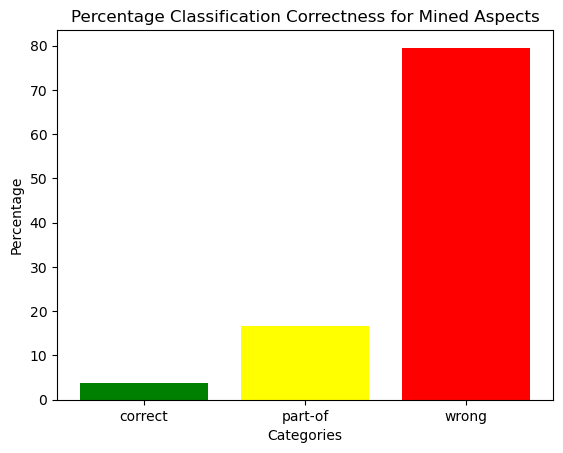

In [341]:
categories = list(mined_aspect_data.keys())
values = list(mined_aspect_data.values())

total_count = sum(data.values())
percentages = [count / total_count * 100 for count in data.values()]
plt.bar(categories, percentages, color=['green', 'yellow', 'red'])
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Percentage Classification Correctness for Mined Aspects')

In [342]:
print(percentages)

[3.88477801268499, 16.569767441860463, 79.54545454545455]


In [288]:
def length_getter(aspect):
    if isinstance(aspect, str):
        return 1
    else:
        return len(aspect)

In [293]:
number_aspects =  big_df['Aspects'].apply(length_getter)
number_mined_aspects = big_df['Mined Aspects'].apply(lambda x: len(x))

In [297]:
mean_num_aspects = number_aspects.mean()
mean_num_mined_aspects = number_mined_aspects.mean()

In [299]:
print(mean_num_aspects)
print(mean_num_mined_aspects)

1.125772641762967
1.8581026605751143


In [298]:
mean_num_mined_aspects/mean_num_aspects 

1.6505132489854382

65% more aspects assigned on average

In [344]:
def lda_aspect_accuracy(aspects, lda_aspects):
    performance = {'correct':0, 'part-of':0, 'wrong':0}
    for n, aspect_list in enumerate(aspects):
        wrong = True
        lda_aspect = list(lda_aspects)[n]
        if isinstance(aspect_list, str):
            if fuzz.ratio(aspect_list,lda_aspect) > 80:
                performance['correct'] += 1
                wrong = False
        elif isinstance(aspect_list, list):
            for aspect in aspect_list: 
                if fuzz.ratio(aspect_list,lda_aspect) > 80:
                    performance['correct'] += 1
                    wrong = False
        if wrong is True:
            performance['wrong'] += 1
    return performance

In [347]:
lda_aspect_data = lda_aspect_accuracy(big_df['Aspects'], big_df['LDA Aspect Labels'])

Text(0.5, 1.0, 'Percentage Classification Correctness for Mined Aspects')

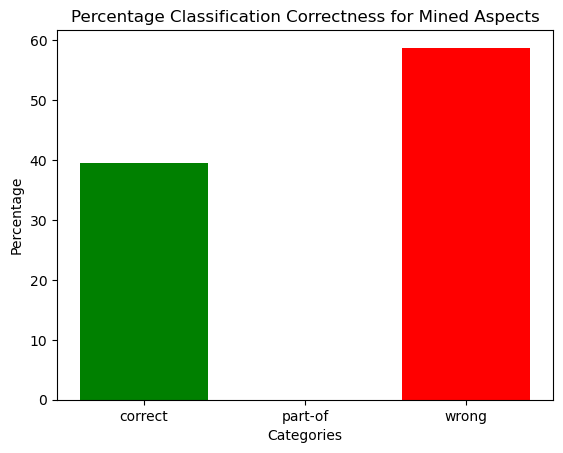

In [349]:
categories = list(lda_aspect_data.keys())
values = list(lda_aspect_data.values())

total_count = sum(data.values())
percentages = [count / total_count * 100 for count in lda_aspect_data .values()]
plt.bar(categories, percentages, color=['green', 'yellow', 'red'])
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Percentage Classification Correctness for Mined Aspects')

In [350]:
percentages

[39.561310782241016, 0.0, 58.7737843551797]

## LDA versus Apriori, for Aspect Labeling results 
LDA aspect labeling accuracy is quite a bit larger for correct aspect labeling. I believe this is mostly because the LDA model has the opition of assigning general as a label if the probability of the topic with greatest assignment prob is less than 50% this means that since our dataset is comprised of majority non labeled (general) sentences. Analyzing the results below are 1.6 times more general aspects than all other labelled aspects combined.

In [361]:
big_df['Aspects'].value_counts()

Aspects
general           2318
phone               61
camera              46
router              33
product             30
                  ... 
prints               1
[feels, looks]       1
photo                1
instruction          1
[sim, card]          1
Name: count, Length: 698, dtype: int64

In [360]:
big_df['Aspects'].value_counts().iloc[0].sum()/big_df['Aspects'].value_counts()[1:].sum()

1.6521739130434783

In [254]:
norton_df.head()

,Sentences,Aspects,Sentiments,Filtered Sentences,Tagged Sentences,Noun Chunks,Mined Aspects,Mined Sentiment Scores,Mined Sentiment Classification,Lazy Sentiment Scores,Lazy Sentiment Classification,LDA Aspect Labels
0,I have read the installation instructions for ...,software,neg,read installation instructions nis 2004 nav 20...,"[(read, VBD), (installation, NN), (instruction...","[(installation, instructions), (nis, 2004, nav...","{instructions, installation, nis 2004, software}","{'instructions': 0.0, 'installation': 0.0, 'ni...","{'instructions': 'neu', 'installation': 'neu',...",0.0000,neu,general
1,Why is it that I can install any other type of...,general,neu,install type software installs works properly,"[(install, VB), (type, NN), (software, NN), (i...","[(type, software, installs)]","{install, installs, software}","{'install': 0, 'installs': 0, 'software': 0}","{'install': 'neu', 'installs': 'neu', 'softwar...",0.0000,neu,instal
2,But if I installed either one of these Norton ...,norton products,neg,installed either one norton products neither w...,"[(installed, VBD), (either, CC), (one, CD), (n...",[(installation)],"{one, norton products, installation}","{'one': 0, 'norton products': 0, 'installation...","{'one': 'neu', 'norton products': 'neu', 'inst...",0.0000,neu,instal
3,"It can not be the computer or the owner, since...","[mcafee anti, general, general]","[neg, neu, neu]",computer owner since purchased mcafee antiviru...,"[(computer, NN), (owner, NN), (since, IN), (pu...","[(computer, owner), (purchased, mcafee, antivi...","{antivirus, mcafee, problems, computer, installs}","{'antivirus': 0.050575, 'mcafee': 0.04046, 'pr...","{'antivirus': 'pos', 'mcafee': 'pos', 'problem...",-0.4767,neg,instal
4,I have used Norton for the past 5 years and fo...,norton,neg,used norton past 5 years last 2 years software...,"[(used, VBD), (norton, NNP), (past, IN), (5, C...","[(norton), (5, years), (software)]","{software, norton}","{'software': 0.0, 'norton': 0.0}","{'software': 'neu', 'norton': 'neu'}",0.0000,neu,download


In [191]:
def aspect_mining_report(product_name, mined_aspects, mined_sentiment_class, num_top_aspects=5):
    mined_aspect_counts = {}
    for i in range(len(mined_aspects)):
        aspect_set = mined_aspects[i]
        sentiment_class_dic = mined_sentiment_class[i]
        for aspect in aspect_set:
            if aspect not in mined_aspect_counts.keys():
                mined_aspect_counts[aspect] = 1
            else:
                mined_aspect_counts[aspect] += 1
    sorted_aspects = dict(sorted(mined_aspect_counts.items(), key=lambda item: item[1], reverse=True))
    top_aspects = list(sorted_aspects.keys())[:num_top_aspects]
    top_sentiments = {top_aspect:{'positive':0, 'neutral':0, 'negative':0} for top_aspect in top_aspects}
    #top_sentiments = {top_aspect:np.array((0,0,0)) for top_aspect in top_aspects}
    for classes in mined_sentiment_class:
        for top_aspect in top_aspects:
            if top_aspect in classes.keys():
                sentiment = classes[top_aspect]
                if sentiment == 'neg':
                    top_sentiments[top_aspect]['negative'] += 1
                elif sentiment == 'neu':
                    top_sentiments[top_aspect]['neutral'] += 1
                elif sentiment == 'pos':
                    top_sentiments[top_aspect]['positive'] += 1
    # print report
    print(product_name)
    for aspect, sentiments in list(top_sentiments.items())[:num_top_aspects]:
        print(f'\t feature: {aspect}')
        num_positive = sentiments['positive']
        print(f'\t\t positive: {num_positive}')
        num_neutral = sentiments['neutral']
        print(f'\t\t neutral: {num_neutral}')
        num_negative = sentiments['negative']
        print(f'\t\t negative: {num_negative}')
              
    return top_sentiments
                          

In [193]:
def true_aspect_sentiments(product_name, aspects, sentiments, num_top_aspects=5):
    aspect_counts = {}
    for aspect_list in aspects:
        if isinstance(aspect_list, str):
            aspect_list = [aspect_list]
        for aspect in aspect_list:
            if aspect not in aspect_counts.keys():
                aspect_counts[aspect] = 1
            else:
                aspect_counts[aspect] += 1
    sorted_aspects = dict(sorted(aspect_counts.items(), key=lambda item: item[1], reverse=True))
    top_aspects = list(sorted_aspects.keys())
    top_sentiments = {top_aspect:{'positive':0, 'neutral':0, 'negative':0} for top_aspect in top_aspects}
    for n, sentiment_list in enumerate(sentiments):
        if isinstance(sentiment_list, str):
            sentiment_list = [sentiment_list]
        aspect_list = aspects[n]
        if isinstance(aspect_list, str):
            aspect_list = [aspect_list]
        for top_aspect in top_aspects:
            if top_aspect in aspect_list:
                sentiment_index = aspect_list.index(top_aspect)
                sentiment = sentiment_list[sentiment_index]
                if sentiment == 'neg':
                    top_sentiments[top_aspect]['negative'] += 1
                elif sentiment == 'neu':
                    top_sentiments[top_aspect]['neutral'] += 1
                elif sentiment == 'pos':
                    top_sentiments[top_aspect]['positive'] += 1
    print(product_name)
    for aspect, sentiments in list(top_sentiments.items())[:num_top_aspects]:
        print(f'\t feature: {aspect}')
        num_positive = sentiments['positive']
        print(f'\t\t positive: {num_positive}')
        num_neutral = sentiments['neutral']
        print(f'\t\t neutral: {num_neutral}')
        num_negative = sentiments['negative']
        print(f'\t\t negative: {num_negative}')
    
    return top_sentiments

In [206]:
sentiments_norton_mined = aspect_mining_report('Norton Mined',
                                                   norton_df['Mined Aspects'],
                                                   norton_df['Mined Sentiment Classification'])
sentiments_norton=true_aspect_sentiments('Norton Real',
                                             norton_df['Aspects'],
                                             norton_df['Sentiments'])

Norton Mined
	 feature: norton
		 positive: 4
		 neutral: 35
		 negative: 6
	 feature: computer
		 positive: 4
		 neutral: 28
		 negative: 1
	 feature: product
		 positive: 5
		 neutral: 21
		 negative: 3
	 feature: program
		 positive: 3
		 neutral: 24
		 negative: 2
	 feature: symantec
		 positive: 2
		 neutral: 23
		 negative: 0
Norton Real
	 feature: general
		 positive: 0
		 neutral: 184
		 negative: 0
	 feature: product
		 positive: 6
		 neutral: 0
		 negative: 14
	 feature: norton
		 positive: 0
		 neutral: 0
		 negative: 10
	 feature: support
		 positive: 0
		 neutral: 0
		 negative: 10
	 feature: installation
		 positive: 2
		 neutral: 0
		 negative: 7


In [205]:
sentiments_hitatchi_mined = aspect_mining_report('Hitatchi Router Mined', hitatch_df['Mined Aspects'], hitatch_df['Mined Sentiment Classification'])
sentiments_hitatchi = true_aspect_sentiments('Hitatchi Router Real', hitatch_df['Aspects'], hitatch_df['Sentiments'])

Hitatchi Router Mined
	 feature: router
		 positive: 25
		 neutral: 58
		 negative: 2
	 feature: table
		 positive: 14
		 neutral: 28
		 negative: 0
	 feature: use
		 positive: 14
		 neutral: 22
		 negative: 2
	 feature: bits
		 positive: 5
		 neutral: 17
		 negative: 2
	 feature: one
		 positive: 3
		 neutral: 16
		 negative: 2
Hitatchi Router Real
	 feature: general
		 positive: 0
		 neutral: 115
		 negative: 0
	 feature: router
		 positive: 39
		 neutral: 0
		 negative: 3
	 feature: price
		 positive: 15
		 neutral: 0
		 negative: 2
	 feature: power
		 positive: 12
		 neutral: 0
		 negative: 2
	 feature: adjustment
		 positive: 7
		 neutral: 0
		 negative: 6


In [196]:
sentiments_canon_powershow_mined = aspect_mining_report('Canon Powershow Mined',
                                                      canon_powershow_df['Mined Aspects'],
                                                      canon_powershow_df['Mined Sentiment Classification'])
sentiments_canon_powershow = true_aspect_sentiments('Canon Powershow Real', 
                                                    canon_powershow_df['Aspects'],
                                                    canon_powershow_df['Sentiments'])

Canon Powershow Mined
	 feature: camera
		 positive: 22
		 neutral: 46
		 negative: 2
	 feature: pictures
		 positive: 10
		 neutral: 16
		 negative: 3
	 feature: sd500
		 positive: 7
		 neutral: 12
		 negative: 1
	 feature: one
		 positive: 4
		 neutral: 9
		 negative: 2
	 feature: quality
		 positive: 7
		 neutral: 7
		 negative: 0
Canon Powershow Real
	 feature: general
		 positive: 0
		 neutral: 103
		 negative: 0
	 feature: camera
		 positive: 25
		 neutral: 0
		 negative: 1
	 feature: lcd
		 positive: 1
		 neutral: 0
		 negative: 8
	 feature: pictures
		 positive: 9
		 neutral: 0
		 negative: 0
	 feature: image
		 positive: 5
		 neutral: 0
		 negative: 1


In [197]:
sentiments_micro_mined = aspect_mining_report('MicroMP3 Mined',
                                                      micro_df['Mined Aspects'],
                                                      micro_df['Mined Sentiment Classification'])
sentiments_micro = true_aspect_sentiments('MicroMP3 Real', 
                                                    micro_df['Aspects'],
                                                    micro_df['Sentiments'])

MicroMP3 Mined
	 feature: player
		 positive: 28
		 neutral: 84
		 negative: 5
	 feature: zen micro
		 positive: 27
		 neutral: 50
		 negative: 6
	 feature: ipod
		 positive: 10
		 neutral: 58
		 negative: 2
	 feature: one
		 positive: 10
		 neutral: 44
		 negative: 5
	 feature: use
		 positive: 16
		 neutral: 28
		 negative: 7
MicroMP3 Real
	 feature: general
		 positive: 0
		 neutral: 995
		 negative: 0
	 feature: look
		 positive: 12
		 neutral: 0
		 negative: 1
	 feature: size
		 positive: 6
		 neutral: 0
		 negative: 0
	 feature: sound
		 positive: 5
		 neutral: 0
		 negative: 0
	 feature: player
		 positive: 3
		 neutral: 0
		 negative: 2


In [198]:
sentiments_linksys_mined = aspect_mining_report('linksys router Mined',
                                                      linksys_df['Mined Aspects'],
                                                      linksys_df['Mined Sentiment Classification'])
sentiments_linksys = true_aspect_sentiments('linksys router Real', 
                                                    linksys_df['Aspects'],
                                                    linksys_df['Sentiments'])

linksys router Mined
	 feature: router
		 positive: 21
		 neutral: 72
		 negative: 1
	 feature: linksys
		 positive: 12
		 neutral: 44
		 negative: 1
	 feature: wireless
		 positive: 4
		 neutral: 35
		 negative: 0
	 feature: setup
		 positive: 8
		 neutral: 26
		 negative: 1
	 feature: one
		 positive: 8
		 neutral: 20
		 negative: 0
linksys router Real
	 feature: general
		 positive: 0
		 neutral: 560
		 negative: 0
	 feature: setup
		 positive: 3
		 neutral: 0
		 negative: 1
	 feature: router
		 positive: 2
		 neutral: 0
		 negative: 0
	 feature: install
		 positive: 1
		 neutral: 0
		 negative: 1
	 feature: wizard
		 positive: 0
		 neutral: 0
		 negative: 2


In [200]:
sentiments_diaper_mined = aspect_mining_report('Diaper Champ Mined',
                                                      diaper_df['Mined Aspects'],
                                                      diaper_df['Mined Sentiment Classification'])
sentiments_diaper = true_aspect_sentiments('Diaper Champ Real',
                                                      diaper_df['Aspects'],
                                                      diaper_df['Sentiments'])

Diaper Champ Mined
	 feature: diapers
		 positive: 10
		 neutral: 25
		 negative: 3
	 feature: diaper champ
		 positive: 15
		 neutral: 18
		 negative: 2
	 feature: use
		 positive: 9
		 neutral: 23
		 negative: 1
	 feature: one
		 positive: 9
		 neutral: 21
		 negative: 2
	 feature: odor
		 positive: 8
		 neutral: 22
		 negative: 1
Diaper Champ Real
	 feature: general
		 positive: 0
		 neutral: 163
		 negative: 0
	 feature: diaper champ
		 positive: 23
		 neutral: 0
		 negative: 5
	 feature: odor
		 positive: 10
		 neutral: 0
		 negative: 5
	 feature: champ
		 positive: 14
		 neutral: 0
		 negative: 0
	 feature: product
		 positive: 12
		 neutral: 0
		 negative: 1


In [202]:
sentiments_canon_mined = aspect_mining_report('Canon S100 Mined',
                                                      canon_df['Mined Aspects'],
                                                      canon_df['Mined Sentiment Classification'])
sentiments_canon = true_aspect_sentiments('Canon S100 real',
                                                      canon_df['Aspects'],
                                                      canon_df['Sentiments'])

Canon S100 Mined
	 feature: camera
		 positive: 20
		 neutral: 60
		 negative: 3
	 feature: pictures
		 positive: 5
		 neutral: 22
		 negative: 0
	 feature: battery
		 positive: 3
		 neutral: 12
		 negative: 1
	 feature: one
		 positive: 0
		 neutral: 16
		 negative: 0
	 feature: use
		 positive: 1
		 neutral: 13
		 negative: 0
Canon S100 real
	 feature: general
		 positive: 0
		 neutral: 127
		 negative: 0
	 feature: camera
		 positive: 20
		 neutral: 0
		 negative: 0
	 feature: size
		 positive: 14
		 neutral: 0
		 negative: 1
	 feature: pictures
		 positive: 7
		 neutral: 0
		 negative: 4
	 feature: small
		 positive: 9
		 neutral: 0
		 negative: 1


## References
Hu, M. and Liu, B., 2004, July. Mining opinion features in customer reviews. In AAAI (Vol. 4, No. 4, pp. 755-760). Available from: https://cdn.aaai.org/AAAI/2004/AAAI04-119.pdf <br>

seatgeek/thefuzz: Fuzzy String Matching in Python [Online], n.d. Available from: https://github.com/seatgeek/thefuzz [Accessed 14 December 2023].<br>

Siblini, W., Kuntz, P. and Meyer, F., 2021. A Review on Dimensionality Reduction for Multi-Label Classification. IEEE Transactions on Knowledge and Data Engineering \[Online\], 33(3), pp.839–857. Available from: https://doi.org/10.1109/TKDE.2019.2940014.<br>

Hutto, C. and Gilbert, E., 2014. VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media [Online], 8(1), pp.216–225. Available from: https://doi.org/10.1609/icwsm.v8i1.14550.
<br>

Pelgrim, R., 2022. Short-Text Topic Modelling: LDA vs GSDMM. Medium [Online]. Available from: https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14 [Accessed 10 January 2024].


